# Chapter 11: Training Deep Neural Networks

### Ensure GPU Env is working correctly

In [1]:
import tensorflow as tf
import os
from tensorflow import keras

In [2]:
tf.__version__

'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [4]:
print("Num of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs Available:  1


In [5]:
import sys
import os
import warnings
sys.version

'3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]'

## Visualization fo the Vanishing/Exploding Gradients Problem 

In [6]:
import numpy as np 
def logit(z):
    return 1 / (1 + np.exp(-z))

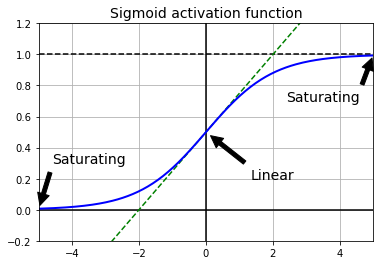

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## List of Initializers in Keras

In [8]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

### Example of He Initialization with Keras

One way of alleviating unstable gradients is using He Initialization with specifically equal numbers of inputs and neurons (or close in this case). These numbers are called the *fan-in* and the *fan-out* of the layer. Normally this is almost impossible to do, but in our case we use a variance equation where we have 2/*fan-in* to help with our initialization strategy. This he normalization is implemented in keras below:

In [9]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [10]:
# can also change so we are using fav-avg instead of fan-in for variance scaling
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Examples of Nonsaturing Activation Functions

In [11]:
# Leaky ReLU
def leaky_reLU(z, alpha=0.01):
    return np.maximum(alpha*z, z)

(-5.0, 5.0, -0.5, 4.3)

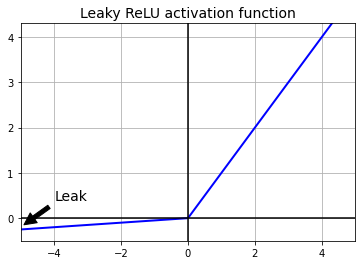

In [12]:
plt.plot(z, leaky_reLU(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.3], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.4), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.3])

## List of Activation Function in Keras

In [13]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [14]:
# ReLU Activation Functions
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### Training a Neural Network - Fashion Dataset with He Normalizatoin and Leaky ReLU Activation

In [15]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_val, X_train = X_train_full[:5000], X_train_full[5000:]
y_val, y_train = y_train_full[:5000], y_train_full[5000:]

In [16]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = [] #rates array
        self.losses = [] # losses array
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate)) # append learning rate to array
        self.losses.append(logs["loss"]) # append loss value to array
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.01)

In [19]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[expon_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 54s 975us/sample - loss: nan - accuracy: 0.2794 - val_loss: nan - val_accuracy: 0.0914


Text(0, 0.5, 'Loss')

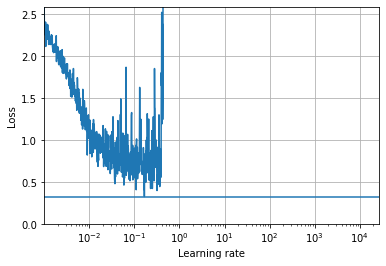

In [20]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [21]:
# Log to library to view later with tensorboard
root_logdir = os.path.join(os.curdir, "my_leakyReLU_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_leakyReLU_logs\\run_2022_01_17-21_21_37'

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=10e-2),
              metrics=["accuracy"])

In [24]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.5290 - accuracy: 0.8083 - val_loss: 0.4024 - val_accuracy: 0.8536
Epoch 2/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4000 - accuracy: 0.8530 - val_loss: 0.3815 - val_accuracy: 0.8640
Epoch 3/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3636 - accuracy: 0.8667 - val_loss: 0.3698 - val_accuracy: 0.8622
Epoch 4/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3422 - accuracy: 0.8738 - val_loss: 0.3536 - val_accuracy: 0.8714
Epoch 5/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3239 - accuracy: 0.8811 - val_loss: 0.3334 - val_accuracy: 0.8786
Epoch 6/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3113 - accuracy: 0.8855 - val_loss: 0.3300 - val_accuracy: 0.8780
Epoch 7/10
55000/55000 [==============================] -

In [109]:
%load_ext tensorboard
%tensorboard --logdir=./my_leakyReLU_logs --port=6008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 11900), started 0:30:24 ago. (Use '!kill 11900' to kill it.)

## PReLU

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr2 = ExponentialLearningRate(factor=1.01)

In [28]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[expon_lr2])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 5s 97us/sample - loss: nan - accuracy: 0.2855 - val_loss: nan - val_accuracy: 0.0914


Text(0, 0.5, 'Loss')

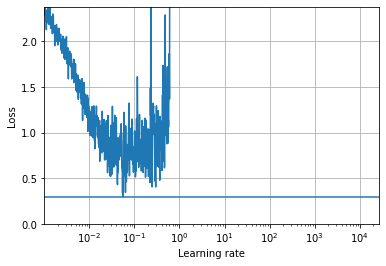

In [29]:
plt.plot(expon_lr2.rates, expon_lr2.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr2.losses), min(expon_lr2.rates), max(expon_lr2.rates))
plt.axis([min(expon_lr2.rates), max(expon_lr2.rates), 0, expon_lr2.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [30]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_leakyReLU_logs\\run_2022_01_17-21_22_26'

In [31]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=10e-2),
              metrics=["accuracy"])

In [33]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)

history2 = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.5353 - accuracy: 0.8076 - val_loss: 0.3849 - val_accuracy: 0.8548
Epoch 2/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3910 - accuracy: 0.8568 - val_loss: 0.3670 - val_accuracy: 0.8670
Epoch 3/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3490 - accuracy: 0.8698 - val_loss: 0.3514 - val_accuracy: 0.8700
Epoch 4/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3214 - accuracy: 0.8795 - val_loss: 0.3210 - val_accuracy: 0.8822
Epoch 5/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.3018 - accuracy: 0.8874 - val_loss: 0.3210 - val_accuracy: 0.8780
Epoch 6/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.2857 - accuracy: 0.8942 - val_loss: 0.3227 - val_accuracy: 0.8816
Epoch 7/10
55000/55000 [==============================] -

In [110]:
%tensorboard --logdir=./my_leakyReLU_logs --port=6008

Reusing TensorBoard on port 6008 (pid 11900), started 0:30:37 ago. (Use '!kill 11900' to kill it.)

## ELU

In [35]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

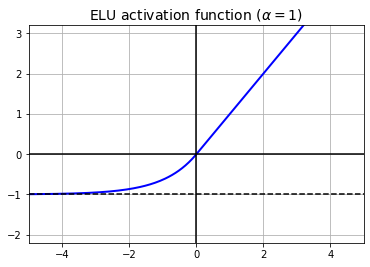

In [36]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [37]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.ELU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.ELU(),
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr3 = ExponentialLearningRate(factor=1.01)

In [39]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[expon_lr3])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 5s 91us/sample - loss: 468998158951.5786 - accuracy: 0.2719 - val_loss: 7924474.3856 - val_accuracy: 0.0914


Text(0, 0.5, 'Loss')

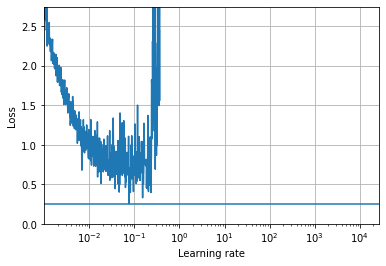

In [40]:
plt.plot(expon_lr3.rates, expon_lr3.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr3.losses), min(expon_lr3.rates), max(expon_lr3.rates))
plt.axis([min(expon_lr3.rates), max(expon_lr3.rates), 0, expon_lr3.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [41]:
run_logdir3 = get_run_logdir()
run_logdir3

'.\\my_leakyReLU_logs\\run_2022_01_17-21_23_18'

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.ELU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.ELU(),
    keras.layers.Dense(10, activation="softmax")
])

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=10e-2),
              metrics=["accuracy"])

In [44]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir3)

history3 = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5194 - accuracy: 0.8113 - val_loss: 0.3901 - val_accuracy: 0.8638
Epoch 2/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3949 - accuracy: 0.8529 - val_loss: 0.3508 - val_accuracy: 0.8722
Epoch 3/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3576 - accuracy: 0.8678 - val_loss: 0.3468 - val_accuracy: 0.8710
Epoch 4/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3336 - accuracy: 0.8765 - val_loss: 0.3373 - val_accuracy: 0.8718
Epoch 5/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3170 - accuracy: 0.8819 - val_loss: 0.3207 - val_accuracy: 0.8800
Epoch 6/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3016 - accuracy: 0.8871 - val_loss: 0.3331 - val_accuracy: 0.8744
Epoch 7/10
55000/55000 [==============================] -

In [111]:
%tensorboard --logdir=./my_leakyReLU_logs --port=6008

Reusing TensorBoard on port 6008 (pid 11900), started 0:30:47 ago. (Use '!kill 11900' to kill it.)

## SeLU

In [46]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [47]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

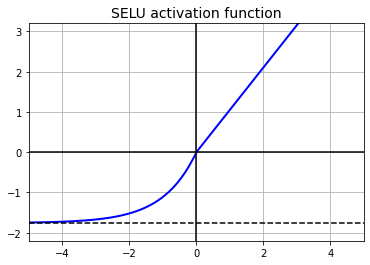

In [48]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

The SELU Hyperparameters are tuned in a way where the mean of the neurons remain close to 0 and the standard deviation remains close to 1. Here is an email using a simple for loop below:

In [49]:
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean -0.00, std deviation 0.91
Layer 200: mean -0.03, std deviation 0.92
Layer 300: mean 0.09, std deviation 0.90
Layer 400: mean 0.01, std deviation 0.82
Layer 500: mean -0.03, std deviation 0.86
Layer 600: mean -0.04, std deviation 0.94
Layer 700: mean 0.03, std deviation 0.92
Layer 800: mean 0.03, std deviation 0.97
Layer 900: mean 0.01, std deviation 0.89


In [50]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [51]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr4 = ExponentialLearningRate(factor=1.01)

In [52]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[expon_lr4])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 5s 97us/sample - loss: nan - accuracy: 0.2658 - val_loss: nan - val_accuracy: 0.0914


Text(0, 0.5, 'Loss')

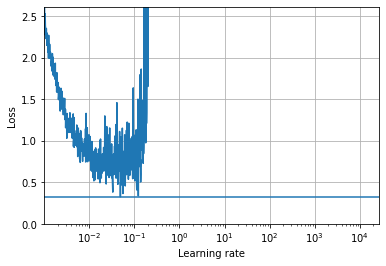

In [53]:
plt.plot(expon_lr4.rates, expon_lr4.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr4.losses), min(expon_lr4.rates), max(expon_lr4.rates))
plt.axis([min(expon_lr4.rates), max(expon_lr4.rates), 0, expon_lr4.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [54]:
run_logdir4 = get_run_logdir()
run_logdir4

'.\\my_leakyReLU_logs\\run_2022_01_17-21_24_11'

In [55]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [56]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=10e-2),
              metrics=["accuracy"])

In [57]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir4)

history4 = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5710 - accuracy: 0.7978 - val_loss: 0.4503 - val_accuracy: 0.8340
Epoch 2/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4242 - accuracy: 0.8461 - val_loss: 0.4323 - val_accuracy: 0.8390
Epoch 3/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3884 - accuracy: 0.8580 - val_loss: 0.3969 - val_accuracy: 0.8588
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3647 - accuracy: 0.8657 - val_loss: 0.3384 - val_accuracy: 0.8790
Epoch 5/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.3447 - accuracy: 0.8726 - val_loss: 0.3551 - val_accuracy: 0.8688
Epoch 6/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3324 - accuracy: 0.8775 - val_loss: 0.3597 - val_accuracy: 0.8666
Epoch 7/10
55000/55000 [==============================] -

In [112]:
%tensorboard --logdir=./my_leakyReLU_logs --port=6008

Reusing TensorBoard on port 6008 (pid 11900), started 0:30:57 ago. (Use '!kill 11900' to kill it.)

Now we will attempt to make a large 100 hidden layer network with the SELU Activation Function for the Fashion MNIST dataset:

In [59]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [60]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [61]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_val_scaled = (X_val - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [62]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_val_scaled, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 15s 270us/sample - loss: 1.5412 - accuracy: 0.3682 - val_loss: 1.0405 - val_accuracy: 0.5716
Epoch 2/5
55000/55000 [==============================] - 13s 232us/sample - loss: 0.9978 - accuracy: 0.6039 - val_loss: 0.8604 - val_accuracy: 0.6638
Epoch 3/5
55000/55000 [==============================] - 13s 240us/sample - loss: 0.8830 - accuracy: 0.6640 - val_loss: 0.7739 - val_accuracy: 0.6994
Epoch 4/5
55000/55000 [==============================] - 13s 237us/sample - loss: 0.8170 - accuracy: 0.7010 - val_loss: 0.6974 - val_accuracy: 0.7470
Epoch 5/5
55000/55000 [==============================] - 13s 235us/sample - loss: 0.7375 - accuracy: 0.7284 - val_loss: 0.6581 - val_accuracy: 0.7646


Now, let us attempt to do the exact same thing, but swamping out our selu activation function with a relu instead and he normalization.

In [63]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [64]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [65]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_val_scaled, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 15s 271us/sample - loss: 2.0261 - accuracy: 0.2279 - val_loss: 1.8246 - val_accuracy: 0.3426
Epoch 2/5
55000/55000 [==============================] - 12s 227us/sample - loss: 1.6011 - accuracy: 0.3684 - val_loss: 1.1632 - val_accuracy: 0.5026
Epoch 3/5
55000/55000 [==============================] - 12s 226us/sample - loss: 1.1587 - accuracy: 0.4981 - val_loss: 0.9785 - val_accuracy: 0.5848
Epoch 4/5
55000/55000 [==============================] - 12s 224us/sample - loss: 0.9313 - accuracy: 0.6296 - val_loss: 1.1233 - val_accuracy: 0.5642
Epoch 5/5
55000/55000 [==============================] - 12s 223us/sample - loss: 0.9067 - accuracy: 0.6537 - val_loss: 0.9454 - val_accuracy: 0.6066


As you can see the performance is not nearly as good with a relu activation function. This is likely due to the vanishing/exploding gradients problem. 

## Batch Normalization in Keras

In [66]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [67]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_228 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_229 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_230 (Dense)            (None, 10)              

In [68]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [69]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=10e-2),
              metrics=["accuracy"])

In [70]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4711 - accuracy: 0.8302 - val_loss: 0.3498 - val_accuracy: 0.8726
Epoch 2/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3577 - accuracy: 0.8691 - val_loss: 0.3266 - val_accuracy: 0.8846
Epoch 3/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.3217 - accuracy: 0.8807 - val_loss: 0.3047 - val_accuracy: 0.8902
Epoch 4/10
55000/55000 [==============================] - 4s 82us/sample - loss: 0.2969 - accuracy: 0.8899 - val_loss: 0.3133 - val_accuracy: 0.8882
Epoch 5/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2779 - accuracy: 0.8963 - val_loss: 0.3306 - val_accuracy: 0.8830
Epoch 6/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2625 - accuracy: 0.9033 - val_loss: 0.2988 - val_accuracy: 0.8964
Epoch 7/10
55000/55000 [==============================] -

As you can see, we get pretty good results when we use batch normalizatoin. We could also apply batch normalizatoin before the activation function and test results. In this case, there is no need for a bias term between layers. So we will set our bias equal to false

In [71]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [72]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=10e-2),
              metrics=["accuracy"])

In [73]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.4650 - accuracy: 0.8318 - val_loss: 0.3439 - val_accuracy: 0.8764
Epoch 2/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3518 - accuracy: 0.8704 - val_loss: 0.3140 - val_accuracy: 0.8906
Epoch 3/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3158 - accuracy: 0.8835 - val_loss: 0.3218 - val_accuracy: 0.8822
Epoch 4/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.2913 - accuracy: 0.8921 - val_loss: 0.2956 - val_accuracy: 0.8892
Epoch 5/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2716 - accuracy: 0.8982 - val_loss: 0.3004 - val_accuracy: 0.8926
Epoch 6/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2539 - accuracy: 0.9056 - val_loss: 0.2925 - val_accuracy: 0.8944
Epoch 7/10
55000/55000 [==============================] -

Batch Normalization before the activation performs slightly in this scenario, but are very close in comparison. 

## Gradient Clipping 

for Keras optimizers accept **clipnorm** or **clipvalue** for the optimizers

In [74]:
#Example
optimizer = keras.optimizers.SGD(clipvalue=1.0)
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## How to Reuse Pretrained Layers

### Resuing a Keras Model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused.

In [75]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_val, y_val)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [76]:
X_train_A.shape

(43986, 28, 28)

In [77]:
X_train_B.shape

(200, 28, 28)

In [78]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [79]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [113]:
# Create a base model and title it model A
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [114]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=10e-3),
                metrics=["accuracy"])

In [115]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 4s 81us/sample - loss: 0.3640 - accuracy: 0.8705 - val_loss: 0.2935 - val_accuracy: 0.8919
Epoch 2/20
43986/43986 [==============================] - 3s 69us/sample - loss: 0.2671 - accuracy: 0.9055 - val_loss: 0.2637 - val_accuracy: 0.9051
Epoch 3/20
43986/43986 [==============================] - 3s 67us/sample - loss: 0.2439 - accuracy: 0.9140 - val_loss: 0.2323 - val_accuracy: 0.9165
Epoch 4/20
43986/43986 [==============================] - 3s 63us/sample - loss: 0.2283 - accuracy: 0.9182 - val_loss: 0.2241 - val_accuracy: 0.9215
Epoch 5/20
43986/43986 [==============================] - 3s 65us/sample - loss: 0.2169 - accuracy: 0.9227 - val_loss: 0.2424 - val_accuracy: 0.9111
Epoch 6/20
43986/43986 [==============================] - 3s 64us/sample - loss: 0.2081 - accuracy: 0.9251 - val_loss: 0.2198 - val_accuracy: 0.9215
Epoch 7/20
43986/43986 [==============================] -

In [116]:
# Now save model A
model_A.save("my_model_A.h5")

In [117]:
# Build model B
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [118]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=10e-2),
                metrics=["accuracy"])

In [119]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 3ms/sample - loss: 3.5071 - accuracy: 0.6650 - val_loss: 1.2275 - val_accuracy: 0.5000
Epoch 2/20
200/200 [==============================] - 0s 573us/sample - loss: 0.4953 - accuracy: 0.8050 - val_loss: 0.0726 - val_accuracy: 0.9787
Epoch 3/20
200/200 [==============================] - 0s 508us/sample - loss: 0.0251 - accuracy: 0.9900 - val_loss: 0.0569 - val_accuracy: 0.9868
Epoch 4/20
200/200 [==============================] - 0s 688us/sample - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0650 - val_accuracy: 0.9828
Epoch 5/20
200/200 [==============================] - 0s 410us/sample - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 0.9878
Epoch 6/20
200/200 [==============================] - 0s 450us/sample - loss: 0.0059 - accuracy: 0.9950 - val_loss: 0.0663 - val_accuracy: 0.9838
Epoch 7/20
200/200 [==============================] - 0s 435us/sample - loss: 0.

In [120]:
model_B.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_254 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_255 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_256 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_257 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_258 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_259 (Dense)            (None, 1)               

Now we will build on top of model A using a stack of model B. We will also show an example of cloning a so it doesn't actually update both models when we begin training.

In [121]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [122]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [123]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=10e-2),
                     metrics=["accuracy"])

In [124]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=5,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=10e-2),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=20,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/5
200/200 [==============================] - 0s 2ms/sample - loss: 0.1752 - accuracy: 0.9350 - val_loss: 0.0510 - val_accuracy: 0.9878
Epoch 2/5
200/200 [==============================] - 0s 583us/sample - loss: 0.0323 - accuracy: 0.9900 - val_loss: 0.0400 - val_accuracy: 0.9919
Epoch 3/5
200/200 [==============================] - 0s 565us/sample - loss: 0.0233 - accuracy: 0.9950 - val_loss: 0.0350 - val_accuracy: 0.9919
Epoch 4/5
200/200 [==============================] - 0s 508us/sample - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.9909
Epoch 5/5
200/200 [==============================] - 0s 418us/sample - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.9899
Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.9899
Epoch 2/20
200/200 [=====================

In [125]:
#Results
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 102us/sample - loss: 0.0427 - accuracy: 0.9890


[0.04274180712341331, 0.989]

In [126]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 93us/sample - loss: 0.0081 - accuracy: 0.9970


[0.008058915600995533, 0.997]

In [127]:
(100 - 98.90) / (100 - 99.70) #Improvement

3.6666666666666825

## Faster Optimizers in Keras

### Momentum Optimization

In [100]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

In [101]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad

In [102]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

### RMSProp

In [103]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam Optimization

In [104]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Adamax Optimization

In [105]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Nadam Optimizatoin

In [106]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling Examples

### Power Scheduling

`lr = lr0 / (1 + steps / s)**c`

* for the base optimizer in Keras, Keras uses `c=1` and `s = 1 / decay`

In [129]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [130]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [131]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

ERROR! Session/line number was not unique in database. History logging moved to new session 523
Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 72us/sample - loss: 0.4903 - accuracy: 0.8291 - val_loss: 0.4003 - val_accuracy: 0.8596
Epoch 2/25
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3814 - accuracy: 0.8643 - val_loss: 0.3779 - val_accuracy: 0.8666
Epoch 3/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3488 - accuracy: 0.8753 - val_loss: 0.3598 - val_accuracy: 0.8708
Epoch 4/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3275 - accuracy: 0.8836 - val_loss: 0.3509 - val_accuracy: 0.8754
Epoch 5/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3124 - accuracy: 0.8888 - val_loss: 0.3415 - val_accuracy: 0.8828
Epoch 6/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3000 - accuracy: 0.8936 - v

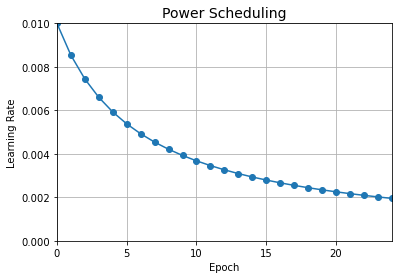

In [132]:
# Visualization using MatPlotLib
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

`lr = lr0 * 0.1**(epoch / s)`

In [133]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [134]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [135]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [136]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[lr_scheduler])

ERROR! Session/line number was not unique in database. History logging moved to new session 524
Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.8565 - accuracy: 0.7574 - val_loss: 1.2223 - val_accuracy: 0.6722
Epoch 2/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.7179 - accuracy: 0.7883 - val_loss: 0.7581 - val_accuracy: 0.8068
Epoch 3/25
55000/55000 [==============================] - 4s 65us/sample - loss: 0.6338 - accuracy: 0.8159 - val_loss: 0.6621 - val_accuracy: 0.7946
Epoch 4/25
55000/55000 [==============================] - 4s 64us/sample - loss: 0.6131 - accuracy: 0.8189 - val_loss: 0.7327 - val_accuracy: 0.7904
Epoch 5/25
55000/55000 [==============================] - 4s 65us/sample - loss: 0.5592 - accuracy: 0.8328 - val_loss: 0.5816 - val_accuracy: 0.8338
Epoch 6/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.5049 - accuracy: 0.8483 - v

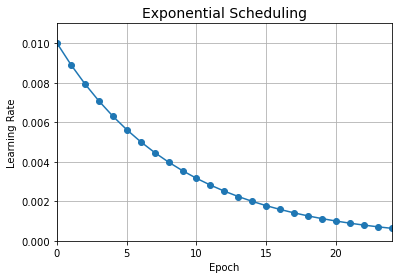

In [137]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Alternatively, the schedule function can take the current learning rate as a second arugment like the following:

In [138]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

Updating the learning rate at each iteration instead of epoch needs a callback class like below:

In [139]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[exp_decay])

ERROR! Session/line number was not unique in database. History logging moved to new session 525
Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 96us/sample - loss: 0.8089 - accuracy: 0.7630 - val_loss: 0.8620 - val_accuracy: 0.6700
Epoch 2/25
55000/55000 [==============================] - 5s 86us/sample - loss: 0.6372 - accuracy: 0.8042 - val_loss: 0.6649 - val_accuracy: 0.8042
Epoch 3/25
55000/55000 [==============================] - 5s 85us/sample - loss: 0.5671 - accuracy: 0.8229 - val_loss: 0.6797 - val_accuracy: 0.8100
Epoch 4/25
55000/55000 [==============================] - 5s 86us/sample - loss: 0.5123 - accuracy: 0.8424 - val_loss: 0.5191 - val_accuracy: 0.8622
Epoch 5/25
55000/55000 [==============================] - 5s 88us/sample - loss: 0.4753 - accuracy: 0.8498 - val_loss: 0.5113 - val_accuracy: 0.8404
Epoch 6/25
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4231 - accuracy: 0.8627 - v

In [140]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

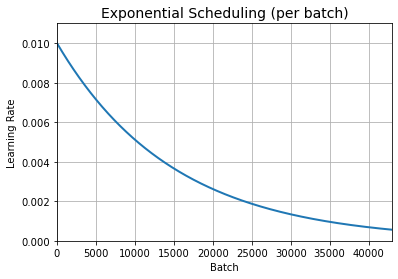

In [141]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [142]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [143]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [144]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.8722 - accuracy: 0.7521 - val_loss: 0.7824 - val_accuracy: 0.7550
Epoch 2/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.8715 - accuracy: 0.7434 - val_loss: 0.8172 - val_accuracy: 0.7416
Epoch 3/25
55000/55000 [==============================] - 4s 75us/sample - loss: 0.9237 - accuracy: 0.7268 - val_loss: 0.8933 - val_accuracy: 0.7126
Epoch 4/25
55000/55000 [==============================] - 4s 69us/sample - loss: 1.0068 - accuracy: 0.6697 - val_loss: 1.2000 - val_accuracy: 0.5774
Epoch 5/25
55000/55000 [==============================] - 4s 67us/sample - loss: 1.1134 - accuracy: 0.6107 - val_loss: 1.2771 - val_accuracy: 0.5486
Epoch 6/25
55000/55000 [==============================] - 4s 69us/sample - loss: 0.8473 - accuracy: 0.6800 - val_loss: 0.8685 - val_accuracy: 0.7414
Epoch 7/25
55000/55000 [==============================] -

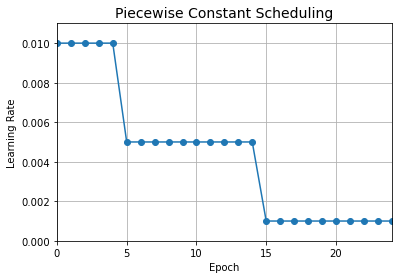

In [145]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [146]:
# We make use of the callback feature in kera to reduce the learning rate when there is a plateau
# for learning
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.5942 - accuracy: 0.8077 - val_loss: 0.4696 - val_accuracy: 0.8412
Epoch 2/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.5105 - accuracy: 0.8350 - val_loss: 0.6462 - val_accuracy: 0.8434
Epoch 3/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.4973 - accuracy: 0.8449 - val_loss: 0.4964 - val_accuracy: 0.8428
Epoch 4/25
55000/55000 [==============================] - 3s 56us/sample - loss: 0.4982 - accuracy: 0.8480 - val_loss: 0.6057 - val_accuracy: 0.8240
Epoch 5/25
55000/55000 [==============================] - 3s 56us/sample - loss: 0.5235 - accuracy: 0.8509 - val_loss: 0.4739 - val_accuracy: 0.8398
Epoch 6/25
55000/55000 [==============================] - 3s 55us/sample - loss: 0.5111 - accuracy: 0.8530 - val_loss: 0.6928 - val_accuracy: 0.8330
Epoch 7/25
55000/55000 [==============================] -

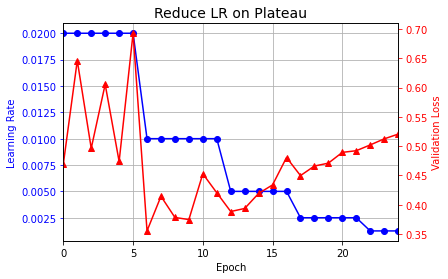

In [147]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## Tensorflow Schedulers

In [148]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.4856 - accuracy: 0.8297 - val_loss: 0.4160 - val_accuracy: 0.8564
Epoch 2/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3789 - accuracy: 0.8663 - val_loss: 0.3815 - val_accuracy: 0.8682
Epoch 3/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3455 - accuracy: 0.8761 - val_loss: 0.3661 - val_accuracy: 0.8720
Epoch 4/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3228 - accuracy: 0.8842 - val_loss: 0.3607 - val_accuracy: 0.8734
Epoch 5/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3055 - accuracy: 0.8911 - val_loss: 0.3603 - val_accuracy: 0.8738
Epoch 6/25
55000/55000 [==============================] - 3s 57us/sample - loss: 0.2931 - accuracy: 0.8956 - val_loss: 0.3435 - val_accuracy: 0.8792
Epoch 7/25
55000/55000 [==============================] -

If we wanted to use the method of piecewise constant scheduling, we would do the following below:

In [149]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

## Example of 1Cycle Scheduling

In [150]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [151]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=10e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 2s 35us/sample - loss: nan - accuracy: 0.3788


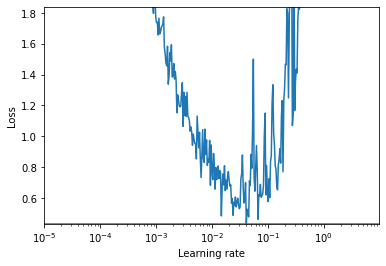

In [152]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [153]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [154]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.6609 - accuracy: 0.7731 - val_loss: 0.4850 - val_accuracy: 0.8330
Epoch 2/25
55000/55000 [==============================] - 1s 17us/sample - loss: 0.4544 - accuracy: 0.8403 - val_loss: 0.4326 - val_accuracy: 0.8530
Epoch 3/25
55000/55000 [==============================] - 1s 19us/sample - loss: 0.4105 - accuracy: 0.8559 - val_loss: 0.4074 - val_accuracy: 0.8590
Epoch 4/25
55000/55000 [==============================] - 1s 19us/sample - loss: 0.3826 - accuracy: 0.8658 - val_loss: 0.3855 - val_accuracy: 0.8670
Epoch 5/25
55000/55000 [==============================] - 1s 20us/sample - loss: 0.3611 - accuracy: 0.8730 - val_loss: 0.3915 - val_accuracy: 0.8570
Epoch 6/25
55000/55000 [==============================] - 1s 20us/sample - loss: 0.3448 - accuracy: 0.8771 - val_loss: 0.3664 - val_accuracy: 0.8740
Epoch 7/25
55000/55000 [==============================] -

## Avoiding Overfitting Using Regularization in Models

## *$\ell_1$ and $\ell_2$ regularization*


In [155]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [156]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 79us/sample - loss: 1.6002 - accuracy: 0.8108 - val_loss: 0.7255 - val_accuracy: 0.8296
Epoch 2/2
55000/55000 [==============================] - 4s 70us/sample - loss: 0.7183 - accuracy: 0.8244 - val_loss: 0.6935 - val_accuracy: 0.8440


In [157]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 79us/sample - loss: 1.6298 - accuracy: 0.8123 - val_loss: 0.7151 - val_accuracy: 0.8348
Epoch 2/2
55000/55000 [==============================] - 4s 67us/sample - loss: 0.7219 - accuracy: 0.8252 - val_loss: 0.6903 - val_accuracy: 0.8388


## Dropout Technique

In [158]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 5s 82us/sample - loss: 0.5708 - accuracy: 0.8021 - val_loss: 0.3802 - val_accuracy: 0.8654
Epoch 2/2
55000/55000 [==============================] - 4s 67us/sample - loss: 0.4208 - accuracy: 0.8452 - val_loss: 0.3361 - val_accuracy: 0.8754


## Alpha Dropout Method

In [159]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 63us/sample - loss: 0.6646 - accuracy: 0.7603 - val_loss: 0.5879 - val_accuracy: 0.8458
Epoch 2/20
55000/55000 [==============================] - 3s 57us/sample - loss: 0.5582 - accuracy: 0.7937 - val_loss: 0.5625 - val_accuracy: 0.8386
Epoch 3/20
55000/55000 [==============================] - 3s 61us/sample - loss: 0.5258 - accuracy: 0.8046 - val_loss: 0.5868 - val_accuracy: 0.8378
Epoch 4/20
55000/55000 [==============================] - 3s 59us/sample - loss: 0.5109 - accuracy: 0.8092 - val_loss: 0.5107 - val_accuracy: 0.8550
Epoch 5/20
55000/55000 [==============================] - 3s 61us/sample - loss: 0.4955 - accuracy: 0.8179 - val_loss: 0.4582 - val_accuracy: 0.8586
Epoch 6/20
55000/55000 [==============================] - 3s 61us/sample - loss: 0.4783 - accuracy: 0.8217 - val_loss: 0.4901 - val_accuracy: 0.8646
Epoch 7/20
55000/55000 [==============================] -

In [160]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 42us/sample - loss: 0.4524 - accuracy: 0.8619


[0.45237642294168473, 0.8619]

In [161]:
model.evaluate(X_train_scaled, y_train)

55000/55000 [==============================] - 2s 45us/sample - loss: 0.3421 - accuracy: 0.8843


[0.3420901405995542, 0.88429093]

In [162]:
history = model.fit(X_train_scaled, y_train)

Train on 55000 samples
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4147 - accuracy: 0.8439


## MC Dropout

In [163]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [164]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.86]],
      dtype=float32)

In [165]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.09, 0.  , 0.88]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.93, 0.  , 0.06]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.74, 0.  , 0.16]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.49, 0.  , 0.26]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.55, 0.  , 0.44]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.41, 0.  , 0.57]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.48, 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.36, 0.  , 0.59]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.6 , 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.65, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.54, 0.  , 0.41]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.23, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.28, 0.  , 0

In [166]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.41, 0.  , 0.47]],
      dtype=float32)

In [167]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.28, 0.  , 0.28]],
      dtype=float32)

In [168]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8716

In [169]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [170]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


In [171]:
mc_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_296 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_297 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_298 (Dense)            (None, 10)              

In [172]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [173]:
mc_model.set_weights(model.get_weights())

In [174]:
# Model ready for MC Dropout
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.39, 0.  , 0.5 ]],
      dtype=float32)

## Max Norm

In [175]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [176]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

ERROR! Session/line number was not unique in database. History logging moved to new session 526
Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4719 - accuracy: 0.8325 - val_loss: 0.3896 - val_accuracy: 0.8552
Epoch 2/2
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3564 - accuracy: 0.8710 - val_loss: 0.3575 - val_accuracy: 0.8706


# End of Chapter Exercises

1. Is it OK to initialize all the weights to the same value as long as that value is
   selected randomly using He initialization?
2. Is it OK to initialize the bias terms to 0?
3. Name three advantages of the SELU activation function over ReLU.
4. In which cases would you want to use each of the following activation functions:
   SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?
5. What may happen if you set the momentum hyperparameter too close to 1 (e.g.,
   0.99999) when using an SGD optimizer?
6. Name three ways you can produce a sparse model.
7. Does dropout slow down training? Does it slow down inference (i.e., making
   predictions on new instances)? What about MC Dropout?
8. Practice training a deep neural network on the CIFAR10 image dataset:


a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but
   it’s the point of this exercise). Use He initialization and the ELU activation
   function.
   
b. Using Nadam optimization and early stopping, train the network on the
   CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_
   data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000
   for training, 10,000 for testing) with 10 classes, so you’ll need a softmax out‐
   put layer with 10 neurons. Remember to search for the right learning rate each
   time you change the model’s architecture or hyperparameters.
   
c. Now try adding Batch Normalization and compare the learning curves: Is it
   converging faster than before? Does it produce a better model? How does it
   affect training speed?
   
d. Try replacing Batch Normalization with SELU, and make the necessary adjust‐
   ements to ensure the network self-normalizes (i.e., standardize the input fea‐
   tures, use LeCun normal initialization, make sure the DNN contains only a
   sequence of dense layers, etc.).
   
e. Try regularizing the model with alpha dropout. Then, without retraining your
   model, see if you can achieve better accuracy using MC Dropout.
   f. Retrain your model using 1cycle scheduling and see if it improves training
   speed and model accuracy

***1. Is it OK to initialize all the weights to the same value as long as that value is
   selected randomly using He initialization?***
   
A: Well the problem with the above is that if all weights were to start with equal values, if the solution requires unequal weights to be developed the system would never learn. We want to BREAK SYMMETRY in our model, not keep it. Regardless of He initialization or not, it is not a good idea.

***2. Is it OK to initialize the bias terms to 0?***

A: Depends on the situation. Usually when doing Batch Normalization layers before activation functions, you can remove the bias term altogether. But if both the weight and bias terms are 0 in the hidden layers, we may arrive at the dead neuron problem. In each iteration of gradient descent the gradient in the previous layer is multiplying by the existing weight and gradient in backprop. If the weight is 0, the new gradient will be zero. Result: A dead neuron. 

***3. Name three advantages of the SELU activation function over ReLU.***

A: 
1. SELU activation function solves the vanishing/exploding gradients problem that exists with ReLU.
2. SELUs have a faster learning rate.
3. SELU activation functions has a nonzero derivative which helps avoid the dying units issue that plagues ReLU. 

***4. In which cases would you want to use each of the following activation functions:
   SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?***

A: SELU: Ideal when the network architecture is *sequential* and input features are standardized.

Leaky ReLU: Ideal when NN Architecture is resulting in dead neurons with ReLU, and if you are trying to improve on ReLU. Generally, Leaky ReLU or PReLU perform better than strict ReLU and they perform well on large image datasets (Much Faster).

ReLU: Ideal if looking to test network with a quick solution as ReLU is the most used activation function in coding libraries and there are hand picked accelerators for ReLU and it is also a very simplistic activation function.

Tanh: Ideal for an output layer if an output is needed between -1 and 1.

Logistic: Ideal for output layers dealing with binary classification (1 or 0 for ex). 

Softmax: Ideal for output layer in NN when looking to output probabilities for mutually exclusive classes (Input objects ONLY belong to one class like the MNIST dataset for Ex.). 

***5. What may happen if you set the momentum hyperparameter too close to 1 (e.g.,
   0.99999) when using an SGD optimizer?***
   
A: If the momentum hyperparam is too close to 1, The optimizer may overshoot completely missing the optimal minimum as it ramps up speed as the iterations grow larger and larger. Or, it could come back towards the minumum and roll back and forth for a very long time before finally converging. Almost like shooting a ball into a net where it rolls around the rim for what feels like forever until going in. 

***6. Name three ways you can produce a sparse model.***

A: 
1. After training the model, get rid of the tiny weights in the neurons by setting them to 0
2. Use regularization terms. Specifically, using l2 regularizatoin during training (zeros out weights).
3. Using the TensorFlow Model Optimization Toolkit: https://www.tensorflow.org/model_optimization

***7. Does dropout slow down training? Does it slow down inference (i.e., making
   predictions on new instances)? What about MC Dropout?***
   
A: Dropout tends to slow down convergence and it typically slows down training. But with that said, it typically trains the model better with better tuning so it can make better predictions on newer instances. It does not affect inference speed because it is only for training, not evaluating. MC Dropout stacks the inferences being made to 10 or more. So inference is slowed in this case but training is nill as MC Dropout doesn't require the model to be retrained or modified in any manner.

In [1]:
# Question #8
'''8. Practice training a deep neural network on the CIFAR10 image dataset:
a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but
it’s the point of this exercise). Use He initialization and the ELU activation
function.
b. Using Nadam optimization and early stopping, train the network on the
CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_
data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000
for training, 10,000 for testing) with 10 classes, so you’ll need a softmax out‐
put layer with 10 neurons. Remember to search for the right learning rate each
time you change the model’s architecture or hyperparameters.
c. Now try adding Batch Normalization and compare the learning curves: Is it
converging faster than before? Does it produce a better model? How does it
affect training speed?
d. Try replacing Batch Normalization with SELU, and make the necessary adjust‐
ements to ensure the network self-normalizes (i.e., standardize the input fea‐
tures, use LeCun normal initialization, make sure the DNN contains only a
sequence of dense layers, etc.).
e. Try regularizing the model with alpha dropout. Then, without retraining your
model, see if you can achieve better accuracy using MC Dropout.
f. Retrain your model using 1cycle scheduling and see if it improves training
speed and model accuracy.
'''
import tensorflow as tf
import os
from tensorflow import keras

### A. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function.

To do A., we will use the following resource from TF: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

it tells us if we assign (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data() that our image data shape is (50000, 32, 32, 3) So we will need to flatten a 32 by 32 by 3 NumPy array. Let us do that now and build our model:

In [2]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
# simple for loop for dense layers
for i in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))

### b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

In [3]:
# Load dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

# cross validation set like before
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_val = X_train_full[:5000]
y_val = y_train_full[:5000]

Now we know we need a softmax output with 10 neurons. Let us add that right now

In [4]:
model.add(keras.layers.Dense(10, activation="softmax"))

We will now need to compile the model with a Nadam Optimizer, we will check for accuracy and we will also use the sparse crossentropy for our loss function when compiling. We use 1Cycle Scheduling in part F., so for now we will just use a smaller learning rate than we have been using in this chapter as we are training a very deep mode. Let's pick something like 10e-5 and see how we do from there.

In [5]:
optimizer = keras.optimizers.Nadam(learning_rate=10e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [6]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20) # early stopping callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("question8_model.h5", save_best_only=True)
run_index = 1 # For each iteration the model runs sequentially
run_logdir = os.path.join(os.curdir, "question8_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) #tensorboard callback
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [10]:
%load_ext tensorboard
%tensorboard --logdir=./question8_logs --port=6010

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 932), started 0:00:56 ago. (Use '!kill 932' to kill it.)

Now it's time to train our model...

In [11]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 60s 1ms/sample - loss: 4.1687 - accuracy: 0.1775 - val_loss: 2.4555 - val_accuracy: 0.2008
Epoch 2/100
45000/45000 [==============================] - 9s 190us/sample - loss: 2.0505 - accuracy: 0.2486 - val_loss: 2.3301 - val_accuracy: 0.2136
Epoch 3/100
45000/45000 [==============================] - 9s 192us/sample - loss: 1.9456 - accuracy: 0.2873 - val_loss: 1.9842 - val_accuracy: 0.2952
Epoch 4/100
45000/45000 [==============================] - 9s 190us/sample - loss: 1.8631 - accuracy: 0.3210 - val_loss: 1.8990 - val_accuracy: 0.3082
Epoch 5/100
45000/45000 [==============================] - 9s 193us/sample - loss: 1.8009 - accuracy: 0.3479 - val_loss: 1.8103 - val_accuracy: 0.3422
Epoch 6/100
45000/45000 [==============================] - 8s 185us/sample - loss: 1.7406 - accuracy: 0.3688 - val_loss: 1.8542 - val_accuracy: 0.3196
Epoch 7/100
45000/45000 [=====================

In [12]:
model = keras.models.load_model("question8_model.h5")
model.evaluate(X_val, y_val)

5000/5000 [==============================] - 1s 156us/sample - loss: 1.5038 - accuracy: 0.4688


[1.5038173973083495, 0.4688]

Looks like going with too deep of a model doesn't do so well... And this is with the validation loss. Let's move onto C. to see if we can improve on this.

### C. Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=10e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20) # early stopping callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("question8_bn_model.h5", save_best_only=True)
run_index = 1 # For each iteration the model runs sequentially
run_logdir = os.path.join(os.curdir, "question8_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val),
          callbacks=callbacks)

model = keras.models.load_model("question8_bn_model.h5")
model.evaluate(X_val, y_val)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 30s 671us/sample - loss: 1.9526 - accuracy: 0.2985 - val_loss: 1.7158 - val_accuracy: 0.3866
Epoch 2/100
45000/45000 [==============================] - 25s 546us/sample - loss: 1.7164 - accuracy: 0.3876 - val_loss: 1.5973 - val_accuracy: 0.4254
Epoch 3/100
45000/45000 [==============================] - 25s 549us/sample - loss: 1.6320 - accuracy: 0.4173 - val_loss: 1.5279 - val_accuracy: 0.4518
Epoch 4/100
45000/45000 [==============================] - 24s 539us/sample - loss: 1.5737 - accuracy: 0.4401 - val_loss: 1.4920 - val_accuracy: 0.4714
Epoch 5/100
45000/45000 [==============================] - 24s 529us/sample - loss: 1.5284 - accuracy: 0.4580 - val_loss: 1.4826 - val_accuracy: 0.4782
Epoch 6/100
45000/45000 [==============================] - 24s 532us/sample - loss: 1.4925 - accuracy: 0.4682 - val_loss: 1.4588 - val_accuracy: 0.4788
Epoch 7/100
45000/45000 [==============

[1.331355502796173, 0.5356]

Wow! Batch normalization was able to get to the lowest validation loss in our previous model by the 5th iteration! That means it is converging faster. The accuracy of this model is higher than the previous mode which is a good sign but the training speed is slower and each epoch is taking on average almost 15seconds longer per epoch. Let's take a quick look in tensorboard to see our results

In [15]:
%tensorboard --logdir=./question8_logs --port=6010

Reusing TensorBoard on port 6010 (pid 932), started 1:09:49 ago. (Use '!kill 932' to kill it.)

Looks good! Let's move onto question D.

### D. Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=10e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20) # early stopping callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("question8_SELU_model.h5", save_best_only=True)
run_index = 1 # For each iteration the model runs sequentially
run_logdir = os.path.join(os.curdir, "question8_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_val_scaled = (X_val - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_val_scaled, y_val),
          callbacks=callbacks)

model = keras.models.load_model("question8_SELU_model.h5")
model.evaluate(X_val_scaled, y_val)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 11s 249us/sample - loss: 1.8241 - accuracy: 0.3435 - val_loss: 1.6951 - val_accuracy: 0.3876
Epoch 2/100
45000/45000 [==============================] - 9s 201us/sample - loss: 1.6135 - accuracy: 0.4267 - val_loss: 1.5994 - val_accuracy: 0.4284
Epoch 3/100
45000/45000 [==============================] - 9s 206us/sample - loss: 1.5115 - accuracy: 0.4624 - val_loss: 1.5367 - val_accuracy: 0.4490
Epoch 4/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.4371 - accuracy: 0.4878 - val_loss: 1.4833 - val_accuracy: 0.4772
Epoch 5/100
45000/45000 [==============================] - 9s 200us/sample - loss: 1.3772 - accuracy: 0.5102 - val_loss: 1.4718 - val_accuracy: 0.4760
Epoch 6/100
45000/45000 [==============================] - 9s 198us/sample - loss: 1.3235 - accuracy: 0.5317 - val_loss: 1.4563 - val_accuracy: 0.4866
Epoch 7/100
45000/45000 [==================

[1.4563379108428955, 0.4866]

From here we can see that our accuracy is around 48.66% which is better than our original model but performed worse than using batch normalization. But this one was much quicker than using batch normalization. Let us move onto question E.

### E. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=10e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20) # early stopping callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("question8_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # For each iteration the model runs sequentially
run_logdir = os.path.join(os.curdir, "question8_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_val_scaled = (X_val - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_val_scaled, y_val),
          callbacks=callbacks)

model = keras.models.load_model("question8_alpha_dropout_model.h5")
model.evaluate(X_val_scaled, y_val)

ERROR! Session/line number was not unique in database. History logging moved to new session 540
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 11s 248us/sample - loss: 1.9448 - accuracy: 0.3145 - val_loss: 1.7141 - val_accuracy: 0.3912
Epoch 2/100
45000/45000 [==============================] - 9s 197us/sample - loss: 1.6524 - accuracy: 0.4126 - val_loss: 1.6167 - val_accuracy: 0.4342
Epoch 3/100
45000/45000 [==============================] - 9s 195us/sample - loss: 1.5324 - accuracy: 0.4535 - val_loss: 1.5807 - val_accuracy: 0.4416
Epoch 4/100
45000/45000 [==============================] - 9s 202us/sample - loss: 1.4545 - accuracy: 0.4833 - val_loss: 1.5606 - val_accuracy: 0.4628
Epoch 5/100
45000/45000 [==============================] - 9s 202us/sample - loss: 1.3910 - accuracy: 0.5064 - val_loss: 1.5056 - val_accuracy: 0.4842
Epoch 6/100
45000/45000 [==============================] - 9s 201us/sample - loss: 1.3324 - accurac

[1.4733000394821167, 0.4834]

Performance is very similar to the other models on the validation set (48.34%). Let us now use the MCAlphaDropout Class to use MC Dropout and check performance.

In [18]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [19]:
# Create new model with MCAlphaDropout
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Next we will add a function to calculate the mean predicted class probability over a set number of iterations. We will iterate 15 times over our data and return a mean of the Y probabilities from numPy. The other function we will add is one to pick the argmax in that array of probabilities or in this case, the most likely class for classification of that instance.

In [21]:
import numpy as np
def mc_dropout_predict_probas(mc_model, X, n_samples=15):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=15):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

ERROR! Session/line number was not unique in database. History logging moved to new session 541


In [22]:
# Now for the prediction
y_pred = mc_dropout_predict_classes(mc_model, X_val_scaled)
accuracy = np.mean(y_pred == y_val[:, 0])
accuracy

0.4822

No improvement accuracy in this case.. it is actually worse than Alpha Dropout in our case... Now we move onto our final question; F.

### F. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=10e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Now let us use the **ExponentialLearningRate** and **find_learning_rate** functions we used early and the **plot_lr_vs_loss** function as well to see our loss/learning rate visualization. We will also need to import the math library to assist

In [32]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
        
        
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

ERROR! Session/line number was not unique in database. History logging moved to new session 545


In [33]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

Train on 45000 samples
45000/45000 [==============================] - 2s 41us/sample - loss: nan - accuracy: 0.1453


(9.999999747378752e-06,
 9.615227699279785,
 1.9660615921020508,
 3.4728370394025534)

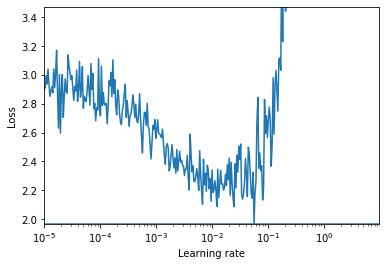

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=10e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Finally, we use our **OneCycleScheduler** Class

In [36]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

ERROR! Session/line number was not unique in database. History logging moved to new session 546


In [37]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[onecycle])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 2s 52us/sample - loss: 2.0668 - accuracy: 0.2841 - val_loss: 1.7679 - val_accuracy: 0.3748
Epoch 2/15
45000/45000 [==============================] - 1s 33us/sample - loss: 1.7749 - accuracy: 0.3742 - val_loss: 1.7146 - val_accuracy: 0.3942
Epoch 3/15
45000/45000 [==============================] - 2s 35us/sample - loss: 1.6308 - accuracy: 0.4219 - val_loss: 1.6468 - val_accuracy: 0.4256
Epoch 4/15
45000/45000 [==============================] - 1s 33us/sample - loss: 1.5486 - accuracy: 0.4501 - val_loss: 1.6107 - val_accuracy: 0.4454
Epoch 5/15
45000/45000 [==============================] - 1s 33us/sample - loss: 1.4975 - accuracy: 0.4705 - val_loss: 1.5785 - val_accuracy: 0.4540
Epoch 6/15
45000/45000 [==============================] - 2s 34us/sample - loss: 1.4563 - accuracy: 0.4844 - val_loss: 1.6025 - val_accuracy: 0.4464
Epoch 7/15
45000/45000 [==============================] -

In [40]:
model.evaluate(X_val_scaled, y_val)

5000/5000 [==============================] - 0s 91us/sample - loss: 1.5851 - accuracy: 0.5234


[1.5851462087631225, 0.5234]

This is insanely fast due to the increased batch sizes! We also managed to get a validation accuracy of 52%! Batch normalization was more accurate but this was much quicker and was obtained almost the same performance! Although the model performance is abysmal, we were able to see the improvements in this exercise.

# End of Notebook